In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Final-Siamese-Drive")


In [ ]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy import asarray
from PIL import Image
import os, fnmatch


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from PIL import Image, ImageFont, ImageDraw
import random
from tensorflow.keras import preprocessing 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
#from tensorflow.keras.engine.topology import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import numpy.random as rng
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

loading images

In [ ]:
#!unzip train.zip

In [ ]:
Files = ['Stop', 'Speed', 'GiveWay', 'Noenter','Animal', 'Nopassing', 'Bump', 'Noparking', 'Oneway', 'Nocycling', 'Novehicles']
#shape = (200, 200)
shape = (100, 100)
label =[]
labelB =[]

data =[]
#Files = [ 'Stop', 'N']
label_val = 0
label_valB = 0
path = '/content/drive/MyDrive/Final-Siamese-Drive/train/Train2/'
data = []
label = []
for files in Files:
    cpath = os.path.join(path, files)
    for img in fnmatch.filter(os.listdir(cpath), '*.png') + fnmatch.filter(os.listdir(cpath), '*.jpeg') :
      #image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
      image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)

      image_array = cv2.resize(image1, shape, interpolation = cv2.INTER_AREA)
      #image_array = cv2.resize(image_0, (96, 96), interpolation = cv2.INTER_AREA)
      #image_array = asarray( cv2.imread(os.path.join(cpath, img)))
      image_array = image_array.astype('float32')
      image_array = image_array / 255.0
      data.append(image_array)
      label.append(label_valB)
      labelB.append(label_val)


    label_val = label_val + 1
    label_valB =  1

data = np.asarray(data)
label = np.asarray(label)
labelB = np.asarray(labelB)

print(label)
print(labelB)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]


In [ ]:
print(label)

In [ ]:
def make_pairs(images, labels):
  pairImages = []
  pairLabels = []
  numClasses = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
  # loop over all images
  for idxA in range(len(images)):
    currentImage = images[idxA]
    label = labels[idxA]
    if label==0:
      idxB = np.random.choice(idx[label])
      posImage = images[idxB]
      pairImages.append([currentImage, posImage])
      pairLabels.append([1])
      negIdx = np.where(labels != label)[0]
      negImage = images[np.random.choice(negIdx)]
      pairImages.append([currentImage, negImage])
      pairLabels.append([0])
    elif label==1:
      currentImage = images[idxA]
      negIdx = np.where(labels ==0)[0]
      negImage = images[np.random.choice(negIdx)]
      pairImages.append([currentImage, negImage])
      pairLabels.append([0])
 # return (np.array(pairImages), np.array(pairLabels))
  pairLabels = np.array(pairLabels).astype('float32')
  return (np.array(pairImages), pairLabels)

def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [ ]:
(inputs, target) = make_pairs(data, label)
#print(inputs[39])

In [ ]:
print(target)

In [ ]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [ ]:
#input_shape = (200, 200, 3)
input_shape = (100, 100, 3)

left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3)))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)


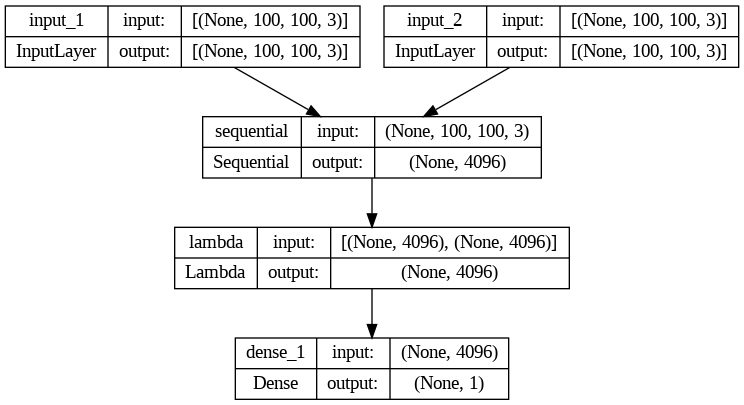

In [ ]:
plot_model(siamese_net, show_shapes=True, show_layer_names=True, to_file='outer-model.png')


In [ ]:

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)
siamese_net.count_params()

27430209

In [ ]:
batch_size = 6
best = -1

In [ ]:
loss=siamese_net.train_on_batch([inputs[:,0], inputs[:,1]],target)


In [ ]:
print(loss)

5.7640814781188965


In [ ]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    y_pred=y_pred.tolist()
    y_true=y_true.tolist()
    pred = np.round(y_pred)

    return(np.mean((pred == y_true))) 

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(data, label)):
  trainY, testY = label[train_index], label[test_index]
  print(trainY)

[1 0 1 1 0 0]


In [ ]:
Extract_path = "/content/drive/MyDrive/Final-Siamese-Drive/Accuracy.txt"
isExist = os.path.exists(Extract_path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(Extract_path)
   print("The new directory is created!")
def write_name(Extract_path, i, epochsize, batchsizes, testsize, testaccuracy):
  i=i
  epoch= epochsize
  batch= batchsizes
  Test_size= testsize
  testAccuracy= testaccuracy

  with open(Extract_path, "a+") as file:
    file.write("\n \n epoch:{}, i:{}, batch:{},Testsize:{}, Test Accuracy{}".format(epoch, i, batch,Test_size,testAccuracy))
    file.close()

In [ ]:
#Attack data set

Files = ['Stop', 'Love']
#Files = ['Stop', 'Strip']
#Files = ['Stop', 'AdvCam']
#Files = ['Stop', 'subtle']
shape = (100, 100)

#Files = ['N', 'P']
label_val = 0
path = '/content/drive/MyDrive/Final-Siamese-Drive/Attack'
dataT = []
labelT = []
for files in Files:
    cpath = os.path.join(path, files)
    #for img in fnmatch.filter(os.listdir(cpath), '*.jpg') + fnmatch.filter(os.listdir(cpath), '*.jpeg') :

    for img in fnmatch.filter(os.listdir(cpath), '*.png') + fnmatch.filter(os.listdir(cpath), '*.jpeg') :
      #image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
      image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)

      image_array = cv2.resize(image1, shape, interpolation = cv2.INTER_AREA)
      #image_array = cv2.resize(image_0, (96, 96), interpolation = cv2.INTER_AREA)
      #image_array = asarray( cv2.imread(os.path.join(cpath, img)))
      image_array = image_array.astype('float32')
      image_array = image_array / 255.0
      dataT.append(image_array)
      labelT.append(label_val)
    label_val = 1
data_Love = np.asarray(dataT)
label_Love = np.asarray(labelT)


#Files = ['Stop', 'Love']
Files = ['Stop', 'Art']
#Files = ['Stop', 'AdvCam']
#Files = ['Stop', 'subtle']

#Files = ['N', 'P']
label_val = 0
path = '/content/drive/MyDrive/Final-Siamese-Drive/Attack'
dataT = []
labelT = []
for files in Files:
    cpath = os.path.join(path, files)
    for img in fnmatch.filter(os.listdir(cpath), '*.jpg') + fnmatch.filter(os.listdir(cpath), '*.jpeg') :

    #for img in fnmatch.filter(os.listdir(cpath), '*.png') + fnmatch.filter(os.listdir(cpath), '*.jpeg') :
      #image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
      image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)

      image_array = cv2.resize(image1, shape, interpolation = cv2.INTER_AREA)
      #image_array = cv2.resize(image_0, (96, 96), interpolation = cv2.INTER_AREA)
      #image_array = asarray( cv2.imread(os.path.join(cpath, img)))
      image_array = image_array.astype('float32')
      image_array = image_array / 255.0
      dataT.append(image_array)
      labelT.append(label_val)
    label_val = 1
data_Art = np.asarray(dataT)
label_Art = np.asarray(labelT)





Files = ['Stop', 'subtle']

#Files = ['N', 'P']
label_val = 0
path = '/content/drive/MyDrive/Final-Siamese-Drive/Attack'
dataT = []
labelT = []
for files in Files:
    cpath = os.path.join(path, files)
    for img in fnmatch.filter(os.listdir(cpath), '*.jpg') + fnmatch.filter(os.listdir(cpath), '*.jpeg') :

    #for img in fnmatch.filter(os.listdir(cpath), '*.png') + fnmatch.filter(os.listdir(cpath), '*.jpeg') :
      #image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
      image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)

      image_array = cv2.resize(image1, shape, interpolation = cv2.INTER_AREA)
      #image_array = cv2.resize(image_0, (96, 96), interpolation = cv2.INTER_AREA)
      #image_array = asarray( cv2.imread(os.path.join(cpath, img)))
      image_array = image_array.astype('float32')
      image_array = image_array / 255.0
      dataT.append(image_array)
      labelT.append(label_val)
    label_val = 1
data_subtle = np.asarray(dataT)
label_subtle = np.asarray(labelT)



Files = ['Stop', 'AdvCam']
#Files = ['Stop', 'subtle']

#Files = ['N', 'P']
label_val = 0
path = '/content/drive/MyDrive/Final-Siamese-Drive/Attack'
dataT = []
labelT = []
for files in Files:
    cpath = os.path.join(path, files)
    #for img in fnmatch.filter(os.listdir(cpath), '*.jpg') + fnmatch.filter(os.listdir(cpath), '*.jpeg') :

    for img in fnmatch.filter(os.listdir(cpath), '*.png') + fnmatch.filter(os.listdir(cpath), '*.jpeg') :
      #image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
      image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)

      image_array = cv2.resize(image1, shape, interpolation = cv2.INTER_AREA)
      #image_array = cv2.resize(image_0, (96, 96), interpolation = cv2.INTER_AREA)
      #image_array = asarray( cv2.imread(os.path.join(cpath, img)))
      image_array = image_array.astype('float32')
      image_array = image_array / 255.0
      dataT.append(image_array)
      labelT.append(label_val)
    label_val = 1
data_AdvCam = np.asarray(dataT)
label_AdvCam = np.asarray(labelT)

In [ ]:
print(label_AdvCam)
print(label_Love)
print(label_Art)

[0 1 1 1 1 1 1 1]
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
def make_test_pairs(images, labels):
  pairImages = []
  pairLabels = []
  numClasses = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
  # loop over all images
  for idxA in range(len(images)):
    currentImage = images[idxA]
    label = labels[idxA]
    negIdx = np.where(labels != label)[0]
    negImage = images[np.random.choice(negIdx)]
    pairImages.append([currentImage, negImage])
    pairLabels.append([1])
 # return (np.array(pairImages), np.array(pairLabels))
  pairLabels = np.array(pairLabels).astype('float32')
  return (np.array(pairImages), pairLabels)

In [ ]:
(ts_AdvCam_pairs, ts_AdvCam_y) = make_test_pairs(data_AdvCam, label_AdvCam)
(ts_Love_pairs, ts_Love_y) = make_test_pairs(data_Love, label_Love)
(ts_subtle_pairs, ts_subtle_y) = make_test_pairs(data_subtle, label_subtle)
(ts_Art_pairs, ts_Art_y) = make_test_pairs(data_Art, label_Art)

In [ ]:
model = siamese_net

loss_AdvCam = model.evaluate(x=[ts_AdvCam_pairs[:,0],ts_AdvCam_pairs[:,1]], y=ts_AdvCam_y)
y_pred_test_AdvCam = model.predict([ts_AdvCam_pairs[:,0], ts_AdvCam_pairs[:,1]])
print(y_pred_test_AdvCam)
test_accuracy_AdvCam = accuracy(ts_AdvCam_y, y_pred_test_AdvCam)
print("test_size= {}, Loss_AdvCam = {},  Test Accuracy_AdvCam = {}".format(test_size, loss_AdvCam , test_accuracy_AdvCam))

loss_Love = model.evaluate(x=[ts_Love_pairs[:,0],ts_Love_pairs[:,1]], y=ts_Love_y)
y_pred_test_Love = model.predict([ts_Love_pairs[:,0], ts_Love_pairs[:,1]])
print(y_pred_test_Love)
test_accuracy_Love = accuracy(ts_Love_y, y_pred_test_Love)
print("test_size= {}, Loss_Love = {},  Test Accuracy_Love = {}".format(test_size, loss_Love, test_accuracy_Love))

loss_subtle = model.evaluate(x=[ts_subtle_pairs[:,0],ts_subtle_pairs[:,1]], y=ts_subtle_y)
y_pred_test_subtle = model.predict([ts_subtle_pairs[:,0], ts_subtle_pairs[:,1]])
print(y_pred_test_subtle)
test_accuracy_subtle = accuracy(ts_subtle_y, y_pred_test_subtle)
print("test_size= {}, Loss_subtle = {},  Test Accuracy_subtle = {}".format(test_size, loss_subtle, test_accuracy_subtle))

loss_Art = model.evaluate(x=[ts_Art_pairs[:,0],ts_Art_pairs[:,1]], y=ts_Art_y)
y_pred_test_Art = model.predict([ts_Art_pairs[:,0], ts_Art_pairs[:,1]])
print(y_pred_test_Art)
test_accuracy_Art = accuracy(ts_Art_y, y_pred_test_Art)
print("test_size= {}, Loss_subtle = {},  Test Accuracy_subtle = {}".format(test_size, loss_subtle, test_accuracy_Art))


In [ ]:
print('label_AdvCam:', label_AdvCam)
print('label_Love:',label_Love)
print('label_subtle:',label_subtle)
print('label_Art:',label_Art)

In [ ]:
#model = siamese_net
from sklearn.model_selection import StratifiedShuffleSplit
test_size=0.9
epoch=25
batch_sizes=4

testSize=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#testSize=[ 0.9, 0.8, 0.7, 0.6, 0.5]

for j, test_size in enumerate(testSize):
  sss = StratifiedShuffleSplit(n_splits=10, test_size=test_size, random_state=0)
  sss.get_n_splits(data, label)
  testAccuracy=[]
  testAccuracy_Art=[]
  testAccuracy_AdvCam=[]
  testAccuracy_Love=[]
  testAccuracy_subtle=[]
  for i, (train_index, test_index) in enumerate(sss.split(data, label)):
    trainX, testX = data[train_index], data[test_index] 
    trainY, testY = label[train_index], label[test_index]
    #print('trainY', trainY)

    (tr_pairs, tr_y ) = make_pairs(trainX, trainY)
    (ts_pairs, ts_y) = make_pairs(testX, testY)
    input_shape = (100, 100, 3)

    left_input = Input(input_shape)
    right_input = Input(input_shape)
    #build convnet to use in each siamese 'leg'
    convnet = Sequential()
    convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(128,(7,7),activation='relu',kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(128,(4,4),activation='relu',kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(256,(4,4),activation='relu',kernel_regularizer=l2(2e-4)))
    convnet.add(Flatten())
    convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3)))

    #call the convnet Sequential model on each of the input tensors so params will be shared
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    #layer to merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    #call this layer on list of two input tensors.
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    model = siamese_net
    optimizer = Adam(0.00006)
    model.compile(loss="binary_crossentropy",optimizer=optimizer)
    history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=epoch, batch_size=batch_sizes, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))
    loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)
    y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
    loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)
    y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
    train_accuracy = accuracy(tr_y, y_pred_train)
    y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
    test_accuracy = accuracy(ts_y, y_pred_test)
    testAccuracy.append(test_accuracy)
    print("testSize= {}, Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(test_size, loss, train_accuracy, test_accuracy))


    loss_AdvCam = model.evaluate(x=[ts_AdvCam_pairs[:,0],ts_AdvCam_pairs[:,1]], y=ts_AdvCam_y)
    y_pred_test_AdvCam = model.predict([ts_AdvCam_pairs[:,0], ts_AdvCam_pairs[:,1]])
    test_accuracy_AdvCam = accuracy(ts_AdvCam_y, y_pred_test_AdvCam)
    testAccuracy_AdvCam.append(test_accuracy_AdvCam)

    print("test_size= {}, Loss_AdvCam = {},  Test Accuracy_AdvCam = {}".format(test_size, loss_AdvCam, test_accuracy_AdvCam))

    loss_Love = model.evaluate(x=[ts_Love_pairs[:,0],ts_Love_pairs[:,1]], y=ts_Love_y)
    y_pred_test_Love = model.predict([ts_Love_pairs[:,0], ts_Love_pairs[:,1]])
    test_accuracy_Love = accuracy(ts_Love_y, y_pred_test_Love)
    testAccuracy_Love.append(test_accuracy_Love)

    print("test_size= {}, Loss_Love = {},  Test Accuracy_Love = {}".format(test_size, loss_Love, test_accuracy_Love))

    loss_subtle = model.evaluate(x=[ts_subtle_pairs[:,0],ts_subtle_pairs[:,1]], y=ts_subtle_y)
    y_pred_test_subtle = model.predict([ts_subtle_pairs[:,0], ts_subtle_pairs[:,1]])
    test_accuracy_subtle = accuracy(ts_subtle_y, y_pred_test_subtle)
    testAccuracy_subtle.append(test_accuracy_subtle)

    print("test_size= {}, Loss_subtle = {},  Test Accuracy_subtle = {}".format(test_size, loss_subtle, test_accuracy_subtle))

    loss_Art = model.evaluate(x=[ts_Art_pairs[:,0],ts_Art_pairs[:,1]], y=ts_Art_y)
    y_pred_test_Art = model.predict([ts_Art_pairs[:,0], ts_Art_pairs[:,1]])
    test_accuracy_Art = accuracy(ts_Art_y, y_pred_test_Art)
    testAccuracy_Art.append(test_accuracy_Art)

    print("test_size= {}, Loss_Art = {},  Test Accuracy_Art = {}".format(test_size, loss_Art, test_accuracy_Art))
  print("test_size= {},testAccuracy= {}:".format(test_size, testAccuracy))
  print('test_size= {},testAccuracy_AdvCam= {}:'.format(test_size,testAccuracy_AdvCam))
  print('test_size= {},testAccuracy_Love= {}:'.format(test_size,testAccuracy_Love))
  print('test_size= {},testAccuracy_subtle= {}:'.format(test_size,testAccuracy_subtle))
  print('test_size= {},testAccuracy_Art= {}:'.format(test_size,testAccuracy_Art))

Streaming output truncated to the last 5000 lines.
Epoch 3/25
2/2 [==============================] - 7s 5s/step - loss: 5.5750 - val_loss: 5.5514
Epoch 4/25
2/2 [==============================] - 6s 3s/step - loss: 5.4612 - val_loss: 5.4539
Epoch 5/25
2/2 [==============================] - 6s 4s/step - loss: 5.3443 - val_loss: 5.3350
Epoch 6/25
2/2 [==============================] - 7s 3s/step - loss: 5.2082 - val_loss: 5.2019
Epoch 7/25
2/2 [==============================] - 5s 3s/step - loss: 5.0708 - val_loss: 5.0788
Epoch 8/25
2/2 [==============================] - 7s 4s/step - loss: 4.9498 - val_loss: 4.9870
Epoch 9/25
2/2 [==============================] - 5s 3s/step - loss: 4.8664 - val_loss: 4.9248
Epoch 10/25
2/2 [==============================] - 7s 5s/step - loss: 4.7914 - val_loss: 4.8787
Epoch 11/25
2/2 [==============================] - 6s 3s/step - loss: 4.7257 - val_loss: 4.8386
Epoch 12/25
2/2 [==============================] - 6s 4s/step - loss: 4.6596 - val_loss: 4.7

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
test_size=0.4
epoch=2
batch_sizes=4
accuracyR=[]

sss = StratifiedShuffleSplit(n_splits=10, test_size=test_size, random_state=0)
sss.get_n_splits(data, label)
optimizer = Adam(0.00006)

for i, (train_index, test_index) in enumerate(sss.split(data, label)):
  model = siamese_net
  model.compile(loss="binary_crossentropy",optimizer=optimizer)
  trainX, testX = data[train_index], data[test_index] 
  trainY, testY = label[train_index], label[test_index]
  (tr_pairs, tr_y ) = make_pairs(trainX, trainY)
  (ts_pairs, ts_y) = make_pairs(testX, testY)
  history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=epoch, batch_size=batch_sizes, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))
  loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)
  y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
  loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)
  y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
  train_accuracy = accuracy(tr_y, y_pred_train)
  y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
  test_accuracy = accuracy(ts_y, y_pred_test)
  accuracyR.append(test_accuracy)

  print("testSize= {}, Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(test_size, loss, train_accuracy, test_accuracy))


In [ ]:
  write_name(Extract_path, i, epoch, batch_sizes, test_size, test_accuracy)

In [ ]:
model.save("/content/drive/MyDrive/Final-Siamese-Drive/my-model")

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Final-Siamese-Drive/my-model")

**Load** ATTACk

In [ ]:
#!unzip attack4.zip

In [ ]:
print(label)

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
def make_test_pairs(images, labels):
  pairImages = []
  pairLabels = []
  numClasses = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
  # loop over all images
  for idxA in range(len(images)):
    currentImage = images[idxA]
    label = labels[idxA]
    negIdx = np.where(labels != label)[0]
    negImage = images[np.random.choice(negIdx)]
    pairImages.append([currentImage, negImage])
    pairLabels.append([1])
 # return (np.array(pairImages), np.array(pairLabels))
  pairLabels = np.array(pairLabels).astype('float32')
  return (np.array(pairImages), pairLabels)

In [ ]:
  (ts_pairs, ts_y) = make_test_pairs(data, label)
  #history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=2, batch_size=6, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))
  #loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)
  #y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
  loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)
  #y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
  #train_accuracy = accuracy(tr_y, y_pred_train)
  y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
  print(y_pred_test)
  test_accuracy = accuracy(ts_y, y_pred_test)
  print("i= {}, Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(i, loss, train_accuracy, test_accuracy))


1/1 [==============================] - 19s 19s/step
[[0.8925605 ]
 [0.8628592 ]
 [0.71744406]
 [0.79634154]
 [0.82873124]
 [0.94369835]
 [0.83222437]
 [0.7558387 ]
 [0.84646374]
 [0.90064174]
 [0.9089488 ]
 [0.851206  ]
 [0.8609659 ]
 [0.8925605 ]
 [0.95737773]
 [0.9214503 ]
 [0.80254525]]
i= 0, Loss = 1.2957345247268677, Train Accuracy = 1.0 Test Accuracy = 1.0


In [ ]:
print(y_pred_test)

[[0.5339691 ]
 [0.7776814 ]
 [0.9685326 ]
 [0.39764762]
 [0.74416685]
 [0.59422904]
 [0.53396916]
 [0.9312172 ]]


In [ ]:
import statistics

model = siamese_net
Total_Accuracy = []
from sklearn.model_selection import StratifiedShuffleSplit

for j in range(1,10):
  testsize = (j)/10
  sss = StratifiedShuffleSplit(n_splits=1, test_size=testsize, random_state=0)
  sss.get_n_splits(data, label)
  Test_Accuracy = []

  for i, (train_index, test_index) in enumerate(sss.split(data, label)):
    trainX, testX = data[train_index], data[test_index] 
    trainY, testY = label[train_index], label[test_index]
    (tr_pairs, tr_y ) = make_pairs(trainX, trainY)
    (ts_pairs, ts_y) = make_pairs(testX, testY)
    history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=1, batch_size=4, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))
    loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)
    y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
    loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)
    y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
    train_accuracy = accuracy(tr_y, y_pred_train)
    y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
    test_accuracy = accuracy(ts_y, y_pred_test)
    Test_Accuracy =Test_Accuracy.append(test_accuracy)
    print("i= {}, Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(i, loss, train_accuracy, test_accuracy))
  Total_Accuracy.append(statistics.mean(Test_Accuracy))



2/2 [==============================] - 15s 2s/step
y_true: [[1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
pred: [[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]
y_true: [[1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
S: 36
mean1: 0.9722222222222222
1/1 [==============================] - 2s 2s/step
y_true: [[1.0], [0.0], [1.0], [0.0]]
pred: [[1.]
 [0.]
 [1.]
 [0.]]
y_true: [[1.0], [0.0], [1.0], [0.0]]
S: 4
mean1: 1.0
i

NameError: ignored

In [ ]:
print(ts_y)

In [ ]:
rms = RMSprop()
  #tf.cast(tr_y, tf.float32)

history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=12, batch_size=6, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])

Epoch 1/12
5/5 [==============================] - 169s 35s/step - loss: 8.1316 - val_loss: 7.7824
Epoch 2/12
5/5 [==============================] - 139s 27s/step - loss: 7.3399 - val_loss: 7.2343
Epoch 3/12
5/5 [==============================] - 133s 27s/step - loss: 6.7163 - val_loss: 6.7835
Epoch 4/12
5/5 [==============================] - 128s 26s/step - loss: 6.2114 - val_loss: 6.3233
Epoch 5/12
5/5 [==============================] - 129s 26s/step - loss: 5.7300 - val_loss: 5.7263
Epoch 6/12
5/5 [==============================] - 139s 28s/step - loss: 5.3023 - val_loss: 5.3085
Epoch 7/12
5/5 [==============================] - 135s 27s/step - loss: 4.8964 - val_loss: 4.9457
Epoch 8/12
5/5 [==============================] - 142s 29s/step - loss: 4.5173 - val_loss: 4.6323
Epoch 9/12
5/5 [==============================] - 135s 27s/step - loss: 4.1620 - val_loss: 4.3204
Epoch 10/12
5/5 [==============================] - 134s 27s/step - loss: 3.8290 - val_loss: 3.9812
Epoch 11/12
5/5 [==

In [ ]:
loaded_2 = tf.keras.models.load_model("my_model")

In [ ]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)


In [ ]:

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
print('y_pred_test', y_pred_test)
print('ts_y', ts_y)
test_accuracy = accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

1/1 [==============================] - 11s 11s/step
y_true: [[1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
pred: [[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]
y_true: [[1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
S: 28
mean1: 1.0
1/1 [==============================] - 5s 5s/step
y_pred_test [[9.6211469e-01]
 [2.2030486e-01]
 [6.3076508e-01]
 [3.0520019e-01]
 [9.0034688e-01]
 [4.7163948e-02]
 [5.0032616e-01]
 [1.7022525e-05]
 [5.0032616e-01]
 [9.0048477e-02]
 [4.5717147e-01]
 [2.2030486e-01]]
ts_y [[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]
y

In [ ]:
import numpy as np

y_pred=[.9, .02, .8, .09, .5, .07, .5, .08, .2, 0, .7, .03]
    

ts_y=[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
y =[round(x) for x in y_pred]
print(y)
print(ts_y)


u=(y == ts_y)
print(u)

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
False


In [ ]:
def initialize_base_network():
    input = Input(shape=(64,64,3), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

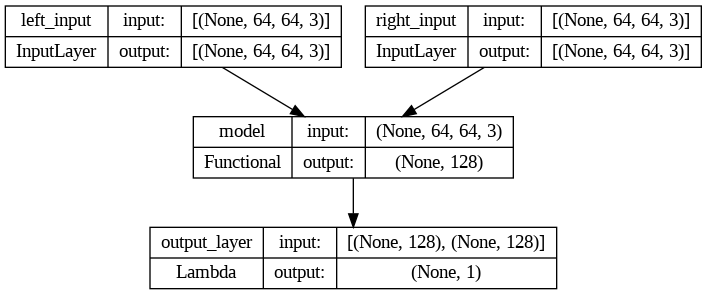

In [ ]:
base_network = initialize_base_network()
# create the left input and point to the base network
input_a = Input(shape=(64,64,3), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(64,64,3), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')


In [ ]:
  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

  trainX, testX = data[train_index], data[test_index] 
  trainY, testY = label[train_index], label[test_index]
  (tr_pairs, tr_y ) = make_pairs(trainX, trainY)
  (ts_pairs, ts_y) = make_pairs(testX, testY)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
sss.get_n_splits(data, label)
for i, (train_index, test_index) in enumerate(sss.split(data, label)):
  print(f"Fold {i}:")
  print(f"  Train: index={train_index}")
  print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 7 16 15  4 17 19 11  2  9  1 12 10 13  6  8  0 18  3]
  Test:  index=[ 5 14]


In [ ]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

accuracy = []
for i, (train_index, test_index) in enumerate(sss.split(data, label)):

  trainX, testX = data[train_index], data[test_index] 
  trainY, testY = label[train_index], label[test_index]
  (tr_pairs, tr_y ) = make_pairs(trainX, trainY)
  (ts_pairs, ts_y) = make_pairs(testX, testY)
  rms = RMSprop()
  #tf.cast(tr_y, tf.float32)

  model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
  history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=40, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))
  loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

  y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
  train_accuracy = compute_accuracy(tr_y, y_pred_train)

  y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
  test_accuracy = compute_accuracy(ts_y, y_pred_test)
  accuracy.append(test_accuracy)

  print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))
  print(f"Fold {i}:")
print(accuracy)

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    print("pred:",pred)
    print("y_true:",y_true)

    mean1 = np.mean(pred == y_true)
    print("y_true:",mean1)

    return(mean1) 

In [ ]:

trainX, testX, trainY, testY = train_test_split(data, label, test_size=0.13)


In [ ]:
(tr_pairs, tr_y ) = make_pairs(trainX, trainY)
(ts_pairs, ts_y) = make_pairs(testX, testY)

In [ ]:
print(tr_y.dtype)

float32


In [ ]:
tr_y = tr_y.astype('float32')
ts_y = ts_y.astype('float32')

In [ ]:
print(tr_y.dtype)

float32


In [ ]:
this_pair = 2

show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

print(tr_y[this_pair])

In [ ]:
# print other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

In [ ]:
base_network = initialize_base_network()


In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D


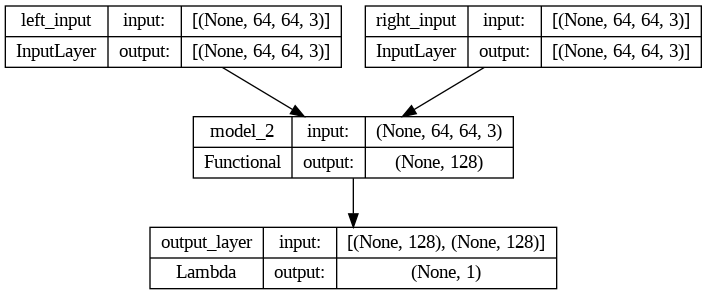

In [ ]:
# create the left input and point to the base network
input_a = Input(shape=(64,64,3), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(64,64,3), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [ ]:
rms = RMSprop()
#tf.cast(tr_y, tf.float32)

print(ts_pairs.dtype)
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=1000, batch_size=28, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

In [ ]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
print('y_pred_test', y_pred_test)
print('ts_y', ts_y)
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

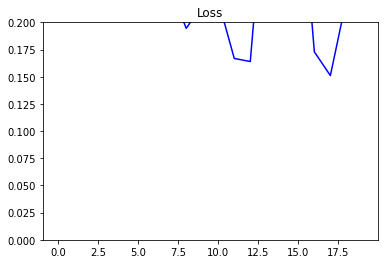

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [ ]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

In [ ]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)

In [ ]:
!unzip Training.zip

In [ ]:
Files = ['Speed', 'Stop']
#Files = ['N', 'P']
label_val = 0
path = '/content/Training'
data = []
label = []
Names = []
for files in Files:
    cpath = os.path.join(path, files)
    for img in fnmatch.filter(os.listdir(cpath), '*.jpeg'):
      #image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
      image1 = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
      

      image_array = cv2.resize(image1, (64, 64), interpolation = cv2.INTER_AREA)
      #image_array = cv2.resize(image_0, (96, 96), interpolation = cv2.INTER_AREA)
      #image_array = asarray( cv2.imread(os.path.join(cpath, img)))
      data.append(image_array)
      label.append(label_val)
      Names.append(img)
    label_val = 1
data = np.asarray(data)
label = np.asarray(label)

trainX, testX, trainY, testY = train_test_split(Names, label, test_size=0.33)


FileNotFoundError: ignored

In [ ]:
def make_pairs(images, labels):
  pairImages = []
  pairLabels = []
  numClasses = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
  # loop over all images
  for idxA in range(len(images)):
    currentImage = images[idxA]
    label = labels[idxA]
    idxB = np.random.choice(idx[label])
    posImage = images[idxB]
    pairImages.append([currentImage, posImage])
    pairLabels.append([1])
    negIdx = np.where(labels != label)[0]
    negImage = images[np.random.choice(negIdx)]
    pairImages.append([currentImage, negImage])
    pairLabels.append([0])
  return (np.array(pairImages), np.array(pairLabels))

In [ ]:
(pairTrain, labelTrain) = make_pairs(trainX,trainY)
(pairTest, labelTest) = make_pairs(testX,testY)

In [ ]:
print(labelTrain)

In [ ]:
 import csv


 with open('Train.csv', 'w', newline='') as file:
     writer = csv.writer(file)
     writer.writerows(pairTrain)
     writer.writerows(labelTrain)


In [ ]:
 import csv


 with open('Test.csv', 'w', newline='') as file:
     writer = csv.writer(file)
     writer.writerows(pairTest)
     writer.writerows(labelTest)

In [ ]:
#model = siamese_net
from sklearn.model_selection import StratifiedShuffleSplit
test_size=0.3
epoch=2
batch_sizes=4
sss = StratifiedShuffleSplit(n_splits=2, test_size=test_size, random_state=0)
sss.get_n_splits(data, label)

for i, (train_index, test_index) in enumerate(sss.split(data, label)):
  optimizer = Adam(0.00006)

  trainX, testX = data[train_index], data[test_index] 
  trainY, testY = label[train_index], label[test_index]
  (tr_pairs, tr_y ) = make_pairs(trainX, trainY)
  (ts_pairs, ts_y) = make_pairs(testX, testY)
  input_shape = (200, 200, 3)
  left_input = Input(input_shape)
  right_input = Input(input_shape)
  #build convnet to use in each siamese 'leg'
  convnet = Sequential()
  convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,kernel_regularizer=l2(2e-4)))
  convnet.add(MaxPooling2D())
  convnet.add(Conv2D(128,(7,7),activation='relu',kernel_regularizer=l2(2e-4)))
  convnet.add(MaxPooling2D())
  convnet.add(Conv2D(128,(4,4),activation='relu',kernel_regularizer=l2(2e-4)))
  convnet.add(MaxPooling2D())
  convnet.add(Conv2D(256,(4,4),activation='relu',kernel_regularizer=l2(2e-4)))
  convnet.add(Flatten())
  convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3)))

  #call the convnet Sequential model on each of the input tensors so params will be shared
  encoded_l = convnet(left_input)
  encoded_r = convnet(right_input)
  #layer to merge two encoded inputs with the l1 distance between them
  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  #call this layer on list of two input tensors.
  L1_distance = L1_layer([encoded_l, encoded_r])
  prediction = Dense(1,activation='sigmoid')(L1_distance)
  siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
  model = siamese_net
  model.compile(loss="binary_crossentropy",optimizer=optimizer)

  history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=epoch, batch_size=batch_sizes, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))
  loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)
  y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
  loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)
  y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
  train_accuracy = accuracy(tr_y, y_pred_train)
  y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
  test_accuracy = accuracy(ts_y, y_pred_test)
  print("testSize= {}, Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(test_size, loss, train_accuracy, test_accuracy))
